# Imports

In [2]:
import pandas as pd
import numpy as np
import catboost as cb
import xgboost as xgb
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterSampler, RandomizedSearchCV
from scipy.stats.distributions import expon
from scipy.stats import uniform
from sklearn.metrics import ConfusionMatrixDisplay
from autoxgb import AutoXGB
import os
import glob
import re
import h2o
import tqdm
import pickle
import os.path

%matplotlib inline
rng = np.random.RandomState(42)

# Functions

In [3]:
def look_at_anti_dist(all_ASR, col_name, col_order=None):
    col_dist = all_ASR.groupby(by='antibiotic_name')[col_name].apply(lambda x: x.value_counts()).reset_index()
    col_dist.columns = ['antibiotic_name', col_name, 'count']
    order = col_dist.groupby(by='antibiotic_name')['count'].apply(sum).sort_values().index
    col_dist = pd.pivot_table(col_dist, values='count', index=['antibiotic_name'],
                    columns=[col_name], aggfunc=np.sum).fillna(0)
    if col_order is not None:
        col_dist = col_dist[col_order]
    ax = col_dist.loc[order].plot.barh(stacked=True, rot=0, figsize=(20,15))
    plt.title('Distribution of ' + col_name+' for each anti-biotics')
    plt.ylabel('antibiotics')
    plt.xlabel('# of measurements')
    plt.legend(loc='lower right')

In [4]:
def print_anti_measure(all_ASR, anti_index):
    anti = all_ASR['antibiotic_name'].value_counts().index[anti_index]
    anti_MIC = all_ASR[all_ASR['antibiotic_name'] == anti]
    anti_MIC['measurement'] = anti_MIC['measurement'].apply(np.log2)
    low = anti_MIC['measurement'].min().round()
    high = anti_MIC['measurement'].max().round()
    hist_range = np.arange(low-0.5, high+1, 1)
    bins_count = pd.DataFrame(anti_MIC.groupby(by='measurement_sign')['measurement'].apply(lambda x: np.histogram(x, bins=hist_range)[0]))
    bins_count = bins_count.merge(pd.DataFrame({'fill': [np.zeros(len(hist_range)-1)]}, index=['=', '<=', '>=', '<', '>']), left_index=True, right_index=True, how='right')
    bins_count['measurement'].fillna(bins_count['fill'], inplace=True)
    pd.DataFrame(bins_count['measurement'].tolist(), index= bins_count.index, columns=hist_range[:-1]+0.5).T.plot.bar(stacked=True)
    plt.title(anti)
    plt.xlabel('log2(mg//L)')
    plt.ylabel('#')


In [5]:
def handle_path_range(path):
    if 'train_no_range' in path:
        return 'no'
    if 'range_distanced_by' in path:
        return 'distanced'
    if 'striped_range' in path:
        return 'distanced'

In [6]:
def add_range(row):
    if row['naive']:
        return 'no'
    elif row['strip_range_train']:
        return 'distanced'
    elif row['distance_range_train']:
        return 'distanced'
    else:
        return 'no'

In [7]:
def handle_path_range_distance(path):
    if 'range_distanced_by' in path:
        return float(path.split('range_distanced_by')[1][0])
    if 'striped_range' in path:
        return 0
    return np.nan

In [8]:
def parse_results(exp_dir_path):
    exp_list =  []
    for path in os.listdir(exp_dir_path):
        if path.split('_')[0] == '1' or path.split('_')[0] == 'largest' or path.split('_')[0] == '.ipynb':
            continue
        if len(path.split('_')) < 2:
            continue
        if len(path.split('_')[-1]) > 3:
            continue
        exp_list.append(path)
    results = pd.DataFrame({
        'exp_path': exp_list,
        'species': [path.split('_')[0] for path in exp_list], 
        'antibiotic': [path.split('_')[1] for path in exp_list], 
        'time_limit': [float(path.split('_')[-2])*60 for path in exp_list], 
        'dup_drop': [len(path.split('fixed_dup'))>1 for path in exp_list], 
        'range': [handle_path_range(path) for path in exp_list], 
        'range_moved': [handle_path_range_distance(path) for path in exp_list], 
    })
    return results

In [9]:
def walk_level(some_dir, level=1):
    some_dir = some_dir.rstrip(os.path.sep)
    assert os.path.isdir(some_dir)
    num_sep = some_dir.count(os.path.sep)
    for root, dirs, files in os.walk(some_dir):
        yield root, dirs, files
        num_sep_this = root.count(os.path.sep)
        if num_sep + level <= num_sep_this:
            del dirs[:]

In [10]:
def parse_param_results(exp_dir_path):
    results = pd.DataFrame({})
    for path in os.listdir(exp_dir_path):
        data_param_path = exp_dir_path+path+'/data_param.csv'
        if not os.path.exists(data_param_path):
            continue
        data_param = pd.read_csv(data_param_path)
        if data_param.loc[0,'strip_range_train']==True:
            data_param['range_moved']=0
        x = next(walk_level(exp_dir_path+path))
        i = 0
        for model_dir in x[1]:
            if '.ipynb' in model_dir:
                continue
            if os.path.exists(exp_dir_path+path+'/'+model_dir+'/model_param.csv'):
                pass
            else:
                model_name = model_dir.split('_')[1]
                if model_name == 'autoxgb':
                    num_models = float(model_dir.split('_')[4])
                    time_limit = float(model_dir.split('_')[7])
                elif model_name == 'h2o':
                    num_models = float(model_dir.split('_')[7])
                    time_limit = float(model_dir.split('_')[4])
                if i==0:
                    data_param['exp_path'] = path+'/'+model_dir
                    data_param['model'] = model_name
                    data_param['num_models'] = num_models
                    data_param['time_limit'] = time_limit
                else:
                    data_param = data_param.append(data_param.loc[[0]].assign(
                        model=model_name, 
                        num_models=num_models, 
                        time_limit=time_limit,
                        exp_path=path+'/'+model_dir,
                    ), ignore_index=True)
            i = i + 1
        results = results.append(data_param).dropna(subset=['exp_path'])
    results.reset_index(drop=True, inplace=True)
    results = results.drop('Unnamed: 0', axis=1)
    results['dup_drop'] = True
    results['range'] = results.apply(lambda row: add_range(row), axis=1)
    return results

In [11]:
def add_exact_metrices(results, equal_meaning = True):
    for i in np.arange(len(results)):
        try:
            exp_name = results['exp_path'].iloc[i]
            if results['dup_drop'].iloc[i]:
                id_col = 'biosample_id'
            else:
                id_col = 'unique_id'
            label = pd.read_csv('../resources/label_{}.csv'.format(exp_name)).loc[0, 'label']
            y_range = pd.read_csv('../resources/y_range_{}.csv'.format(exp_name)).set_index(id_col)
            y = pd.read_csv('../resources/train_{}.csv'.format(exp_name)).set_index(id_col)[label]

            train_res = pd.read_csv('../experiments/{}/oof_predictions.csv'.format(exp_name)).set_index(id_col).merge(y, left_index=True, right_index=True, how='inner')
            train_res = train_res.loc[set(train_res.index)-set(y_range.index)]
            train_res.columns=['y_pred', 'y_true']
            train_res['y_true'] = np.round(train_res['y_true'])
            min_true = train_res['y_true'].min()
            max_true = train_res['y_true'].max(axis=0)
            train_res['y_pred'] = train_res['y_pred'].clip(lower=min_true, upper=max_true)
            train_res['residual'] = train_res['y_true'] - train_res['y_pred']
            train_res['y_pred'] = np.round(train_res['y_pred'])
            train_res['round_residual'] = train_res['y_true'] - train_res['y_pred']
            train_res['error'] = train_res['round_residual'].abs() <1
            train_res['error2'] = train_res['round_residual'].abs() <2


            y = pd.read_csv('../resources/test_{}.csv'.format(exp_name)).set_index(id_col)[label]
            test_res = pd.read_csv('../experiments/{}/test_predictions.csv'.format(exp_name)).set_index(id_col).merge(y, left_index=True, right_index=True, how='inner')
            test_res = test_res.loc[set(test_res.index)-set(y_range.index)]
            test_res.columns=['y_pred', 'y_true']
            test_res['y_true'] = np.round(test_res['y_true'])
            min_true = test_res['y_true'].min()
            max_true = test_res['y_true'].max(axis=0)
            test_res['y_pred'] = test_res['y_pred'].clip(lower=min_true, upper=max_true)
            test_res['residual'] = test_res['y_true'] - test_res['y_pred']
            test_res['y_pred'] = np.round(test_res['y_pred'])
            test_res['round_residual'] = test_res['y_true'] - test_res['y_pred']
            test_res['error'] = test_res['round_residual'].abs() <1
            test_res['error2'] = test_res['round_residual'].abs() <2


            regression_res = pd.DataFrame({
                'exact RMSE': [np.sqrt(train_res['residual'].pow(2).mean()), np.sqrt(test_res['residual'].pow(2).mean())],
                'exact_rounded RMSE': [np.sqrt(train_res['round_residual'].pow(2).mean()), np.sqrt(test_res['round_residual'].pow(2).mean())],
                'exact_accuracy': [train_res['error'].mean(), test_res['error'].mean()],
                'exact_accuracy2': [train_res['error2'].mean(), test_res['error2'].mean()],
            }, index=['train', 'test'])

            range_res = pd.read_csv('../experiments/{}/range_preds.csv'.format(exp_name)).set_index(id_col).merge(y_range, left_index=True, right_index=True, how='inner')
            range_res.columns=['y_pred'] + list(range_res.columns.values)[1:]
            range_res['values'] = np.round(range_res['values'])
            range_res['updated_values'] = np.nan
            range_res['updated_direction'] = np.nan
            if equal_meaning:
                    range_res.loc[range_res['direction'] == '>=','updated_values'] = range_res['values'] - 1
                    range_res.loc[range_res['direction'] == '<=','updated_values'] = range_res['values'] + 1
            range_res.loc[range_res['direction'] == '>=','updated_direction'] = '>'
            range_res.loc[range_res['direction'] == '<=','updated_direction'] = '<'

            range_res.loc[:,'updated_values'].fillna(range_res['values'], inplace=True)
            range_res.loc[:,'updated_direction'].fillna(range_res['direction'], inplace=True)

            range_res.loc[range_res['updated_direction'] == '>','error'] = (range_res['y_pred'] > range_res['updated_values'])
            range_res.loc[range_res['updated_direction'] == '<','error'] = (range_res['y_pred'] < range_res['updated_values'])
            range_res.loc[range_res['updated_direction'] == '>','error2'] = (range_res['y_pred'] > range_res['updated_values'] - 1)
            range_res.loc[range_res['updated_direction'] == '<','error2'] = (range_res['y_pred'] < range_res['updated_values'] + 1)
            y = pd.read_csv('../resources/train_{}.csv'.format(exp_name)).set_index(id_col)[label]
            train_res_index = pd.read_csv('../experiments/{}/oof_predictions.csv'.format(exp_name)).set_index(id_col).merge(y, left_index=True, right_index=True, how='inner').index
            train_range_res = range_res.loc[set(range_res.index).intersection(set(train_res_index))]
            test_range_res = range_res.loc[set(range_res.index) - set(train_res_index)]
            for key, res in {'train': train_range_res, 'test': test_range_res}.items():
                range_confusion = res.groupby(by=['direction', 'values'])['error'].agg(['count', 'sum']).replace(True, 1)
                range_confusion['perc'] = range_confusion['sum'] / range_confusion['count']
                range_confusion.columns = ['range_total', 'range_true', 'range_accuracy']
                range_confusion = pd.DataFrame(range_confusion.stack()).T.swaplevel(i=2, j=0, axis=1)
                range_confusion.index=[key]
                regression_res = pd.concat([regression_res, range_confusion], axis=1)
            regression_res_cleaned = pd.DataFrame({})
            for col in regression_res.columns:
                if len(regression_res[[col]].columns) > 1:
                    regression_res_cleaned[col] = regression_res[[col]].iloc[:,0].fillna(regression_res[[col]].iloc[:,1])
                else:
                    regression_res_cleaned[col] = regression_res[[col]]
            regression_res = regression_res_cleaned
            regression_res['range_accuracy'] = [
                train_range_res['error'].mean(),
                test_range_res['error'].mean(),
            ]
            regression_res['range_accuracy'].fillna(0, inplace=True)
            regression_res['range_accuracy2'] = [
                train_range_res['error2'].mean(),
                test_range_res['error2'].mean(),
            ]
            regression_res['range_accuracy2'].fillna(0, inplace=True)
            regression_res['range_size'] = [
                len(train_range_res),
                len(test_range_res),
            ]
            regression_res['range_size'].fillna(0, inplace=True)
            regression_res['exact_size'] = [
                len(train_res),
                len(test_res),
            ]
            regression_res['accuracy'] = (regression_res['exact_accuracy'].fillna(0) * regression_res['exact_size'].fillna(0) \
                + regression_res['range_accuracy'] * regression_res['range_size']) \
                / (regression_res['range_size'] + regression_res['exact_size'].fillna(0))
            regression_res['essential_agreement'] = (regression_res['exact_accuracy2'].fillna(0) * regression_res['exact_size'].fillna(0) \
                + regression_res['range_accuracy2'] * regression_res['range_size']) \
                / (regression_res['range_size'] + regression_res['exact_size'].fillna(0))

            regression_res = pd.DataFrame(regression_res.unstack()).T

            regression_res.columns = ['{}_{}'.format(col[0], col[1]) 
                       for col in regression_res.columns ]
            regression_res.index=[i]
            regression_res['exp_done'] = True
        except:
            regression_res = pd.DataFrame({}, index=[0])
            regression_res['exp_done'] = False
        regression_res.index=[i]
        results = pd.concat([results,pd.DataFrame(columns=regression_res.columns)])
        results.update(regression_res)
    return results
        

In [12]:
def add_exact_param_metrices(results, equal_meaning = True):
    for i in np.arange(len(results)):
        try:
            exp_name = strat_results['exp_path'].iloc[i]
            data_dir = exp_name.split('/')[0]
            id_col = 'biosample_id'
            label = pd.read_csv('../experiments/{}/label.csv'.format(data_dir)).loc[0, 'label']
            y_range = pd.read_csv('../experiments/{}/y_range.csv'.format(data_dir)).set_index(id_col)
            y = pd.read_csv('../experiments/{}/train.csv'.format(data_dir)).rename(columns={"Unnamed: 0": id_col})[[id_col, label]]
            if strat_results['model'].iloc[i]=='autoxgb':
                train_res = pd.read_csv('../experiments/{}/oof_predictions.csv'.format(exp_name)).set_index(id_col)
                train_res.columns = ['predict']
                train_res = train_res.merge(y, left_index=True, right_index=True, how='inner').set_index(id_col)
            elif strat_results['model'].iloc[i]=='h2o':
                train_res = pd.read_csv('../experiments/{}/train_preds.csv'.format(exp_name)).drop('Unnamed: 0',axis=1).merge(y, left_index=True, right_index=True, how='inner').set_index(id_col)

            train_res = train_res.loc[set(train_res.index)-set(y_range.index)]
            train_res.columns=['y_pred', 'y_true']
            train_res['y_true'] = np.round(train_res['y_true'])
            min_true = train_res['y_true'].min()
            max_true = train_res['y_true'].max(axis=0)
            train_res['y_pred'] = train_res['y_pred'].clip(lower=min_true, upper=max_true)
            train_res['residual'] = train_res['y_true'] - train_res['y_pred']
            train_res['y_pred'] = np.round(train_res['y_pred'])
            train_res['round_residual'] = train_res['y_true'] - train_res['y_pred']
            train_res['error'] = train_res['round_residual'].abs() <1
            train_res['error2'] = train_res['round_residual'].abs() <2

            y = pd.read_csv('../experiments/{}/test.csv'.format(data_dir)).rename(columns={"Unnamed: 0": id_col})[[id_col, label]]
            if strat_results['model'].iloc[i]=='autoxgb':
                test_res = pd.read_csv('../experiments/{}/test_predictions.csv'.format(exp_name)).set_index(id_col)
                test_res.columns = ['predict']
                test_res = test_res.merge(y, left_index=True, right_index=True, how='inner').set_index(id_col)
            elif strat_results['model'].iloc[i]=='h2o':
                test_res = pd.read_csv('../experiments/{}/test_preds.csv'.format(exp_name)).drop('Unnamed: 0',axis=1).merge(y, left_index=True, right_index=True, how='inner').set_index(id_col)
            test_res = test_res.loc[set(test_res.index)-set(y_range.index)]
            test_res.columns=['y_pred', 'y_true']
            test_res['y_true'] = np.round(test_res['y_true'])
            min_true = test_res['y_true'].min()
            max_true = test_res['y_true'].max(axis=0)
            test_res['y_pred'] = test_res['y_pred'].clip(lower=min_true, upper=max_true)
            test_res['residual'] = test_res['y_true'] - test_res['y_pred']
            test_res['y_pred'] = np.round(test_res['y_pred'])
            test_res['round_residual'] = test_res['y_true'] - test_res['y_pred']
            test_res['error'] = test_res['round_residual'].abs() <1
            test_res['error2'] = test_res['round_residual'].abs() <2

            regression_res = pd.DataFrame({
                'exact RMSE': [np.sqrt(train_res['residual'].pow(2).mean()), np.sqrt(test_res['residual'].pow(2).mean())],
                'exact_rounded RMSE': [np.sqrt(train_res['round_residual'].pow(2).mean()), np.sqrt(test_res['round_residual'].pow(2).mean())],
                'exact_accuracy': [train_res['error'].mean(), test_res['error'].mean()],
                'exact_accuracy2': [train_res['error2'].mean(), test_res['error2'].mean()],
            }, index=['train', 'test'])

            if strat_results['model'].iloc[i]=='autoxgb':
                range_res = pd.read_csv('../experiments/{}/range_preds.csv'.format(exp_name)).set_index(id_col).merge(y_range, left_index=True, right_index=True, how='inner')
            elif strat_results['model'].iloc[i]=='h2o':
                range_res = pd.read_csv('../experiments/{}/range_preds.csv'.format(exp_name)).drop('Unnamed: 0',axis=1).merge(y_range.reset_index(), left_index=True, right_index=True, how='inner').set_index(id_col)
            range_res.columns=['y_pred'] + list(range_res.columns.values)[1:]
            range_res['values'] = np.round(range_res['values'])
            range_res['updated_values'] = np.nan
            range_res['updated_direction'] = np.nan
            if equal_meaning:
                    range_res.loc[range_res['direction'] == '>=','updated_values'] = range_res['values'] - 1
                    range_res.loc[range_res['direction'] == '<=','updated_values'] = range_res['values'] + 1
            range_res.loc[range_res['direction'] == '>=','updated_direction'] = '>'
            range_res.loc[range_res['direction'] == '<=','updated_direction'] = '<'
            range_res.loc[:,'updated_values'].fillna(range_res['values'], inplace=True)
            range_res.loc[:,'updated_direction'].fillna(range_res['direction'], inplace=True)

            range_res.loc[range_res['updated_direction'] == '>','error'] = (range_res['y_pred'] > range_res['updated_values'])
            range_res.loc[range_res['updated_direction'] == '<','error'] = (range_res['y_pred'] < range_res['updated_values'])
            range_res.loc[range_res['updated_direction'] == '>','error2'] = (range_res['y_pred'] > range_res['updated_values'] - 1)
            range_res.loc[range_res['updated_direction'] == '<','error2'] = (range_res['y_pred'] < range_res['updated_values'] + 1)

            y = pd.read_csv('../experiments/{}/train.csv'.format(data_dir)).rename(columns={"Unnamed: 0": id_col})[[id_col, label]]
            if strat_results['model'].iloc[i]=='autoxgb':
                train_res = pd.read_csv('../experiments/{}/oof_predictions.csv'.format(exp_name)).set_index(id_col)
                train_res.columns = ['predict']
                train_res = train_res.merge(y, left_index=True, right_index=True, how='inner').set_index(id_col)
            elif strat_results['model'].iloc[i]=='h2o':
                train_res_index = pd.read_csv('../experiments/{}/train_preds.csv'.format(exp_name)).drop('Unnamed: 0',axis=1).merge(y, left_index=True, right_index=True, how='inner').set_index(id_col).index
            train_range_res = range_res.loc[set(range_res.index).intersection(set(train_res_index))]
            test_range_res = range_res.loc[set(range_res.index) - set(train_res_index)]

            for key, res in {'train': train_range_res, 'test': test_range_res}.items():
                range_confusion = res.groupby(by=['direction', 'values'])['error'].agg(['count', 'sum']).replace(True, 1)
                range_confusion['perc'] = range_confusion['sum'] / range_confusion['count']
                range_confusion.columns = ['range_total', 'range_true', 'range_accuracy']
                range_confusion = pd.DataFrame(range_confusion.stack()).T.swaplevel(i=2, j=0, axis=1)
                range_confusion.index=[key]
                regression_res = pd.concat([regression_res, range_confusion], axis=1)

            regression_res_cleaned = pd.DataFrame({})
            for col in regression_res.columns:
                if len(regression_res[[col]].columns) > 1:
                    regression_res_cleaned[col] = regression_res[[col]].iloc[:,0].fillna(regression_res[[col]].iloc[:,1])
                else:
                    regression_res_cleaned[col] = regression_res[[col]]
            regression_res = regression_res_cleaned
            regression_res['range_accuracy'] = [
                train_range_res['error'].mean(),
                test_range_res['error'].mean(),
            ]
            regression_res['range_accuracy'].fillna(0, inplace=True)
            regression_res['range_accuracy2'] = [
                train_range_res['error2'].mean(),
                test_range_res['error2'].mean(),
            ]
            regression_res['range_accuracy2'].fillna(0, inplace=True)
            regression_res['range_size'] = [
                len(train_range_res),
                len(test_range_res),
            ]
            regression_res['range_size'].fillna(0, inplace=True)
            regression_res['exact_size'] = [
                len(train_res),
                len(test_res),
            ]
            regression_res['exact_size'].fillna(0, inplace=True)
            regression_res['accuracy'] = (regression_res['exact_accuracy'].fillna(0) * regression_res['exact_size'].fillna(0) \
                + regression_res['range_accuracy'] * regression_res['range_size']) \
                / (regression_res['range_size'] + regression_res['exact_size'].fillna(0))
            regression_res['essential_agreement'] = (regression_res['exact_accuracy2'].fillna(0) * regression_res['exact_size'].fillna(0) \
                + regression_res['range_accuracy2'] * regression_res['range_size']) \
                / (regression_res['range_size'] + regression_res['exact_size'].fillna(0))

            regression_res = pd.DataFrame(regression_res.unstack()).T

            regression_res.columns = ['{}_{}'.format(col[0], col[1]) 
                       for col in regression_res.columns ]
            regression_res.index=[i]
            regression_res['exp_done'] = True
        except:
            regression_res = pd.DataFrame({}, index=[0])
            regression_res['exp_done'] = False
        regression_res.index=[i]
        results = pd.concat([results,pd.DataFrame(columns=regression_res.columns)])
        results.update(regression_res)
    return results
        

# Load data

## DataSet

In [10]:
data = pd.read_csv('../resources/tot_filtered_data.csv')
with open("../resources/final_labels", "rb") as fp:
    labels = pickle.load(fp)
with open("../resources/final_features", "rb") as fp:
    features = pickle.load(fp)
    

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Meta Data

In [11]:
ASR_data = pd.read_csv('../resources/filtered_ASR_data.csv')

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Exploration

In [15]:
species2merge = data[['biosample_id', 'species_fam']]
filtered_ASR = ASR_data.drop('species_fam', axis=1).merge(species2merge, on='biosample_id')

In [19]:
# look_at_anti_dist(filtered_ASR, 'measurement_sign', col_order=None)

In [20]:
# look_at_anti_dist(filtered_ASR, 'units', col_order=None)

In [21]:
# look_at_anti_dist(filtered_ASR, 'species_fam', col_order=None)

# Cleaning

In [16]:
filtered_ASR['biosample_id'].describe()

count            62929
unique            4011
top       SAMN04448236
freq                29
Name: biosample_id, dtype: object

## bad units

In [17]:
filtered_ASR = filtered_ASR[filtered_ASR['units']=='mg/L']

In [18]:
filtered_ASR['biosample_id'].describe()

count            62857
unique            4009
top       SAMN04448231
freq                29
Name: biosample_id, dtype: object

## Filter species

In [19]:
filtered_ASR = filtered_ASR[filtered_ASR['species_fam']!='senterica']
filtered_ASR = filtered_ASR[filtered_ASR['species_fam']!='spneumoniae']
filtered_ASR['biosample_id'].describe()

count            27888
unique            1456
top       SAMN04448236
freq                29
Name: biosample_id, dtype: object

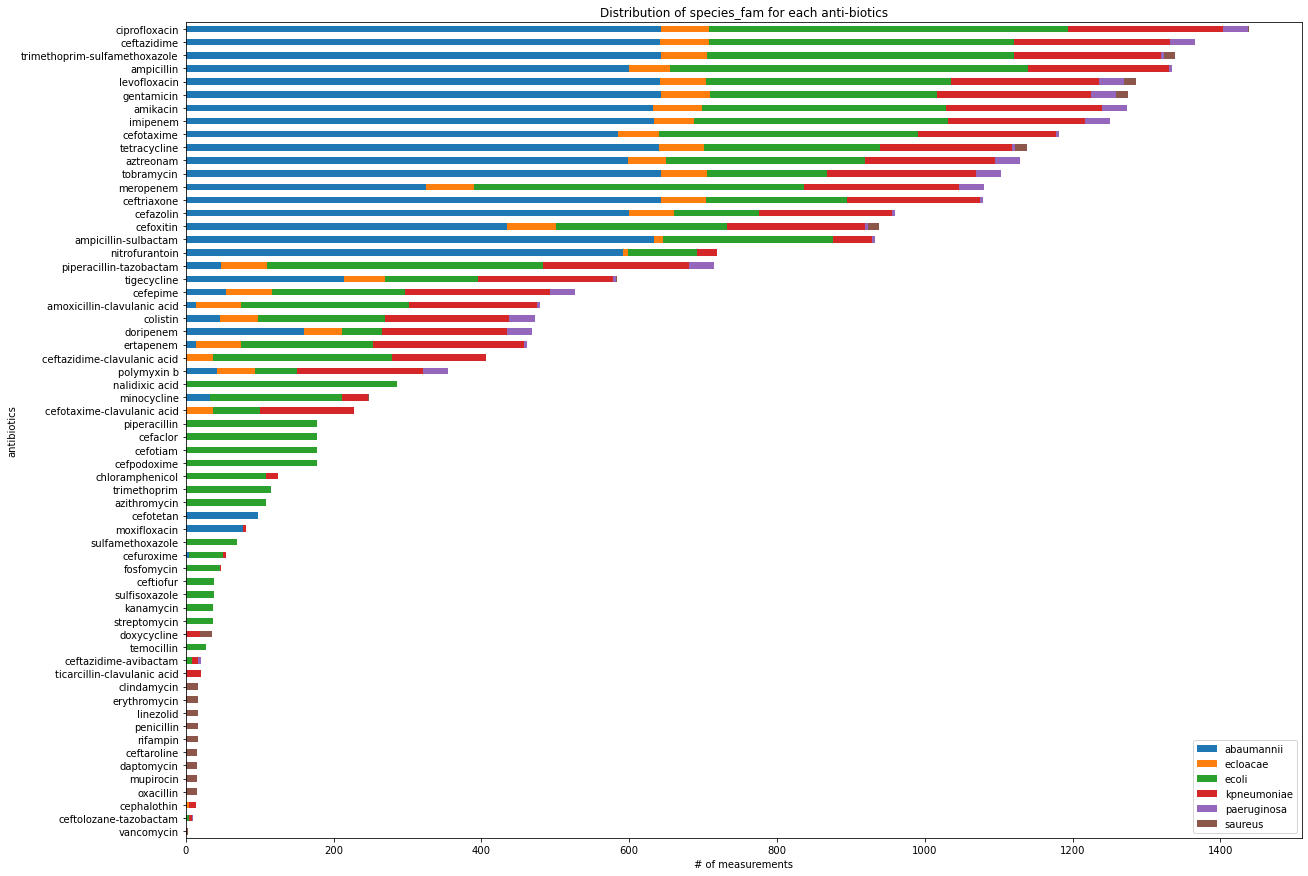

In [20]:
look_at_anti_dist(filtered_ASR, 'species_fam', col_order=None)

In [21]:
species = filtered_ASR['species_fam'].value_counts().reset_index()['index'].iloc[0]

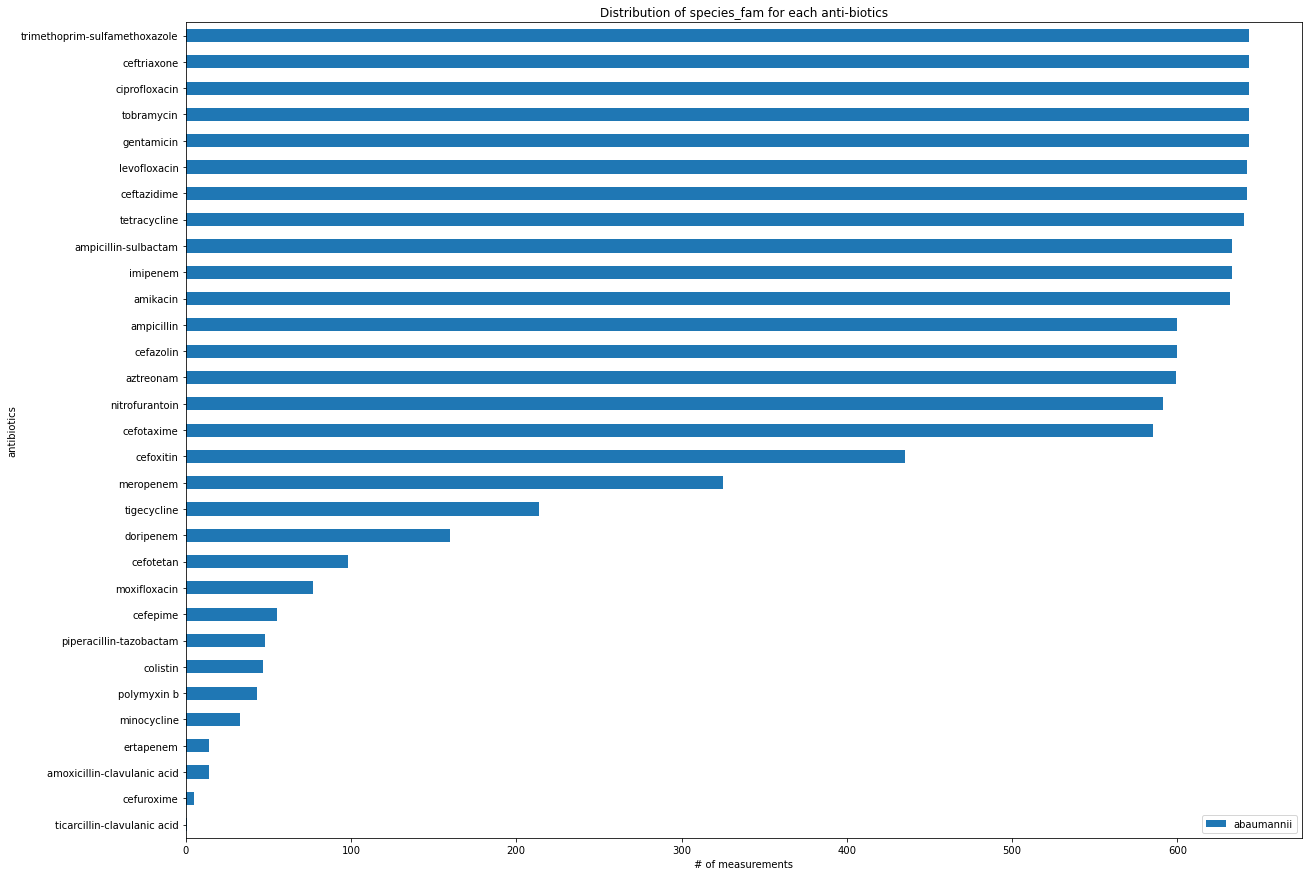

In [22]:
filtered_ASR = filtered_ASR[filtered_ASR['species_fam'] == species]
look_at_anti_dist(filtered_ASR, 'species_fam')

## filter range sighs

In [23]:
# filtered_ASR = filtered_ASR[filtered_ASR['measurement_sign']=='=']

In [24]:
filtered_ASR['biosample_id'].describe()

count            11581
unique             643
top       SAMN04014876
freq                25
Name: biosample_id, dtype: object

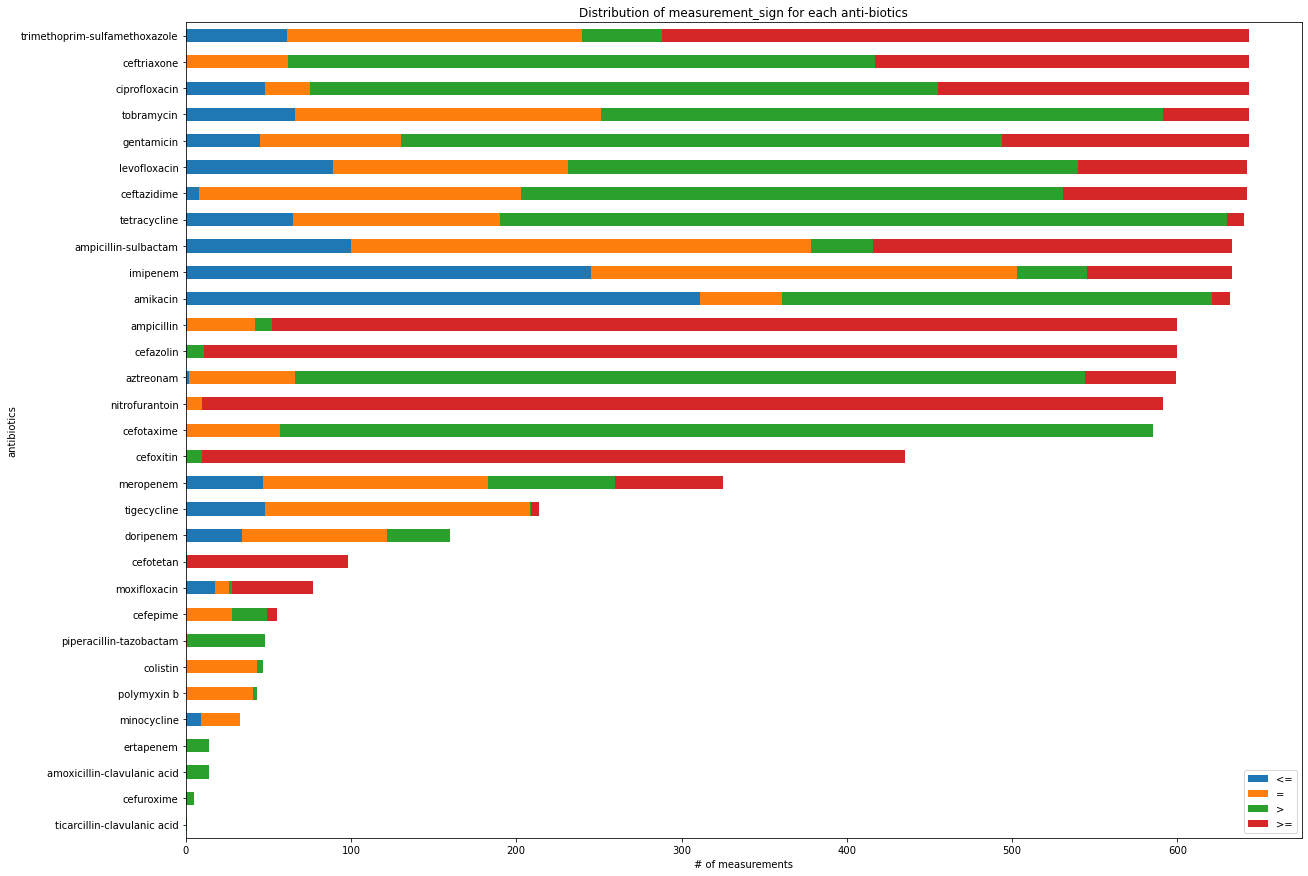

In [25]:
look_at_anti_dist(filtered_ASR, 'measurement_sign', col_order=None)

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


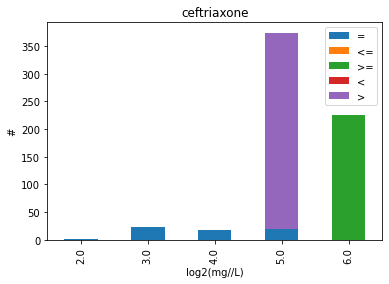

In [27]:
print_anti_measure(filtered_ASR, 1)

In [32]:
for i in np.arange(10):
    print_anti_measure(filtered_ASR, i)

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## list of valid labels:

In [19]:
filtered_ASR['antibiotic_name'].value_counts()

tobramycin                       643
ceftriaxone                      643
gentamicin                       643
trimethoprim-sulfamethoxazole    643
ciprofloxacin                    643
levofloxacin                     642
ceftazidime                      642
tetracycline                     640
imipenem                         633
ampicillin-sulbactam             633
amikacin                         632
ampicillin                       600
cefazolin                        600
aztreonam                        599
nitrofurantoin                   591
cefotaxime                       585
cefoxitin                        435
meropenem                        325
tigecycline                      214
doripenem                        160
cefotetan                         98
moxifloxacin                      77
cefepime                          55
piperacillin-tazobactam           48
colistin                          47
polymyxin b                       43
minocycline                       33
a

In [20]:
anti_list = filtered_ASR['antibiotic_name'].value_counts().index.values

In [21]:
anti_list

array(['tobramycin', 'ceftriaxone', 'gentamicin',
       'trimethoprim-sulfamethoxazole', 'ciprofloxacin', 'levofloxacin',
       'ceftazidime', 'tetracycline', 'imipenem', 'ampicillin-sulbactam',
       'amikacin', 'ampicillin', 'cefazolin', 'aztreonam',
       'nitrofurantoin', 'cefotaxime', 'cefoxitin', 'meropenem',
       'tigecycline', 'doripenem', 'cefotetan', 'moxifloxacin',
       'cefepime', 'piperacillin-tazobactam', 'colistin', 'polymyxin b',
       'minocycline', 'amoxicillin-clavulanic acid', 'ertapenem',
       'cefuroxime', 'ticarcillin-clavulanic acid'], dtype=object)

In [22]:
filtered_ASR.set_index('biosample_id', inplace=True)

## set general data columns

In [23]:
data.set_index('biosample_id', inplace=True)

In [24]:
data.columns

Index(['Unnamed: 0', 'species_fam', 'run_id', 'sulfisoxazole', 'ampicillin',
       'chloramphenicol', 'tetracycline', 'amoxicillin-clavulanic acid',
       'azithromycin', 'nalidixic acid',
       ...
       'OXA-132->seq_id', 'OXA-132->seq_cov', 'OKP-B-7->seq_id',
       'OKP-B-7->seq_cov', 'dfrA21->seq_id', 'dfrA21->seq_cov',
       'CMY-111->seq_id', 'CMY-111->seq_cov', 'mefE->seq_id', 'mefE->seq_cov'],
      dtype='object', length=1288)

In [25]:
data.drop(['Unnamed: 0', 'species_fam', 'run_id'], axis=1, inplace=True)

In [26]:
data

,sulfisoxazole,ampicillin,chloramphenicol,tetracycline,amoxicillin-clavulanic acid,azithromycin,nalidixic acid,cefoxitin,ceftiofur,gentamicin,...,OXA-132->seq_id,OXA-132->seq_cov,OKP-B-7->seq_id,OKP-B-7->seq_cov,dfrA21->seq_id,dfrA21->seq_cov,CMY-111->seq_id,CMY-111->seq_cov,mefE->seq_id,mefE->seq_cov
biosample_id,,,,,,,,,,,,,,,,,,,,,
SAMD00126359,NaN,> 7.0,NaN,NaN,NaN,NaN,> 4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMD00126360,NaN,> 7.0,NaN,NaN,NaN,NaN,> 4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMD00126362,NaN,> 7.0,NaN,NaN,NaN,NaN,> 4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMD00126363,NaN,> 7.0,NaN,NaN,NaN,NaN,> 4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMD00126364,NaN,> 7.0,NaN,NaN,NaN,NaN,> 4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMN05201745,<= 4.0,<= 0.0,= 2.0,> 5.0,<= 0.0,= 2.0,= 1.0,= 1.0,= -1.0,= -1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMN05201746,= 6.0,<= 0.0,= 2.0,<= 2.0,<= 0.0,= 2.0,= 2.0,= 1.0,= 0.0,<= -2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAMN05201749,> 8.0,> 5.0,= 3.0,> 5.0,> 5.0,= 2.0,= 2.0,= 5.0,= 3.0,= -1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Results

## all results

In [13]:
results = parse_results('../experiments/')

In [14]:
results = results[results['dup_drop']==True]
results = add_exact_metrices(results)
results = results[results['exp_done']==True]
results.reset_index(inplace=True, drop=True)

In [15]:
results

,exp_path,species,antibiotic,time_limit,dup_drop,range,range_moved,exact RMSE_train,exact RMSE_test,exact_rounded RMSE_train,...,"('range_true', -1.0, '>')_train","('range_true', -1.0, '>')_test","('range_accuracy', -1.0, '>')_train","('range_accuracy', -1.0, '>')_test","('range_total', 0.0, '>')_train","('range_total', 0.0, '>')_test","('range_true', 0.0, '>')_train","('range_true', 0.0, '>')_test","('range_accuracy', 0.0, '>')_train","('range_accuracy', 0.0, '>')_test"
0,abaumannii_ampicillin-sulbactam_fixed_dup_trai...,abaumannii,ampicillin-sulbactam,3600.0,True,no,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,abaumannii_tobramycin_fixed_dup_striped_range_...,abaumannii,tobramycin,3600.0,True,distanced,0.0,0.973715,1.148586,0.974933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,abaumannii_tobramycin_fixed_dup_range_distance...,abaumannii,tobramycin,3600.0,True,distanced,5.0,0.427294,0.344915,0.46291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,abaumannii_tobramycin_fixed_dup_range_distance...,abaumannii,tobramycin,3600.0,True,distanced,2.0,0.629164,0.606441,0.664726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,abaumannii_imipenem_fixed_dup_train_no_range_f...,abaumannii,imipenem,3600.0,True,no,NaN,0.971445,1.037073,0.969842,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,abaumannii_ceftriaxone_fixed_dup_range_distanc...,abaumannii,ceftriaxone,3600.0,True,distanced,5.0,0.510073,0.13619,0.52915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,abaumannii_ceftriaxone_fixed_dup_range_distanc...,abaumannii,ceftriaxone,3600.0,True,distanced,2.0,1.160021,1.561203,1.183216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,abaumannii_ceftazidime_fixed_dup_train_no_rang...,abaumannii,ceftazidime,3600.0,True,no,NaN,0.960613,1.354935,1.020621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,abaumannii_ceftriaxone_fixed_dup_striped_range...,abaumannii,ceftriaxone,3600.0,True,distanced,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,abaumannii_tobramycin_fixed_dup_train_no_range...,abaumannii,tobramycin,3600.0,True,no,NaN,0.632102,0.671468,0.687654,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [288]:
strat_results = parse_param_results('../experiments/')
strat_results = add_exact_param_metrices(strat_results)

In [ ]:
results = pd.concat([results, strat_results], axis=0)
results['species_sep'].fillna(True, inplace=True)
results['antibiotic_sep'].fillna(True, inplace=True)
results['model'].fillna('autoxgb', inplace=True)
results

In [294]:
strat_results['essential_agreement_test']

0      0.65261
1     0.674699
2     0.678715
3     0.553872
4      0.26936
        ...   
82    0.579125
83    0.579125
84         NaN
85         NaN
86    0.954887
Name: essential_agreement_test, Length: 87, dtype: object

In [325]:
results['exact_size'] = results['exact_size_train'] + results['exact_size_test']
results['range_size'] = results['range_size_train'] + results['range_size_test']
results['size'] = results['exact_size'] + results['range_size']
results

,exp_path,species,antibiotic,time_limit,dup_drop,range,range_moved,exact RMSE_train,exact RMSE_test,exact_rounded RMSE_train,...,"('range_accuracy', -1.0, '>')_test","('range_total', 0.0, '>')_train","('range_total', 0.0, '>')_test","('range_true', 0.0, '>')_train","('range_true', 0.0, '>')_test","('range_accuracy', 0.0, '>')_train","('range_accuracy', 0.0, '>')_test",exact_size,range_size,size
0,abaumannii_ampicillin-sulbactam_fixed_dup_trai...,abaumannii,ampicillin-sulbactam,3600.0,True,no,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,435.0,435.0
1,abaumannii_tobramycin_fixed_dup_striped_range_...,abaumannii,tobramycin,3600.0,True,distanced,0.0,0.973715,1.148586,0.974933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.0,189.0,325.0
2,abaumannii_tobramycin_fixed_dup_range_distance...,abaumannii,tobramycin,3600.0,True,distanced,5.0,0.427294,0.344915,0.46291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,126,179
3,abaumannii_tobramycin_fixed_dup_range_distance...,abaumannii,tobramycin,3600.0,True,distanced,2.0,0.629164,0.606441,0.664726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160,54,214
4,abaumannii_imipenem_fixed_dup_train_no_range_f...,abaumannii,imipenem,3600.0,True,no,NaN,0.971445,1.037073,0.969842,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.0,189.0,325.0
5,abaumannii_ceftriaxone_fixed_dup_range_distanc...,abaumannii,ceftriaxone,3600.0,True,distanced,5.0,0.510073,0.13619,0.52915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.0,72.0,160.0
6,abaumannii_ceftriaxone_fixed_dup_range_distanc...,abaumannii,ceftriaxone,3600.0,True,distanced,2.0,1.160021,1.561203,1.183216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44,142,186
7,abaumannii_ceftazidime_fixed_dup_train_no_rang...,abaumannii,ceftazidime,3600.0,True,no,NaN,0.960613,1.354935,1.020621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,178.0,209.0
8,abaumannii_ceftriaxone_fixed_dup_striped_range...,abaumannii,ceftriaxone,3600.0,True,distanced,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,98,98
9,abaumannii_tobramycin_fixed_dup_train_no_range...,abaumannii,tobramycin,3600.0,True,no,NaN,0.632102,0.671468,0.687654,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160,54,214


In [295]:
strat_results['exact_size'] = strat_results['exact_size_train'] + strat_results['exact_size_test']
strat_results['range_size'] = strat_results['range_size_train'] + strat_results['range_size_test']
strat_results['size'] = strat_results['exact_size'] + strat_results['range_size']
strat_results

,naive,strip_range_train,distance_range_train,reg_stratified,species_sep,antibiotic_sep,exp_describtion,species,antibiotic,exp_path,...,"('range_accuracy', 3.0, '<')_test","('range_total', 4.0, '<')_train","('range_total', 4.0, '<')_test","('range_true', 4.0, '<')_train","('range_true', 4.0, '<')_test","('range_accuracy', 4.0, '<')_train","('range_accuracy', 4.0, '<')_test",exact_size,range_size,size
0,True,False,False,True,True,True,naive_strat,abaumannii,tobramycin,abaumannii_tobramycin_naive_strat/model_h2o_tr...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185,458,643
1,True,False,False,True,True,True,naive_strat,abaumannii,tobramycin,abaumannii_tobramycin_naive_strat/model_autoxg...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185,458,643
2,True,False,False,True,True,True,naive_strat,abaumannii,tobramycin,abaumannii_tobramycin_naive_strat/model_h2o_tr...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185,458,643
3,True,False,False,True,True,True,naive_strat,abaumannii,ceftriaxone,abaumannii_ceftriaxone_naive_strat/model_h2o_t...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,581.0,643.0
4,True,False,False,True,True,True,naive_strat,abaumannii,ceftriaxone,abaumannii_ceftriaxone_naive_strat/model_autox...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.0,581.0,643.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,True,False,False,True,True,True,naive_strat,abaumannii,amikacin,abaumannii_amikacin_naive_strat/model_h2o_trai...,...,0.130268,NaN,48,NaN,24,NaN,0.5,50,582,632
83,True,False,False,True,True,True,naive_strat,abaumannii,amikacin,abaumannii_amikacin_naive_strat/model_h2o_trai...,...,0.130268,NaN,48,NaN,24,NaN,0.5,50,582,632
84,True,False,False,False,True,False,multi_naive,abaumannii,NaN,abaumannii_measurement_multi_naive/model_h2o_t...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,True,False,False,False,True,False,multi_naive,kpneumoniae,NaN,kpneumoniae_measurement_multi_naive/model_h2o_...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
list(results.columns)

['exp_path',
 'species',
 'antibiotic_name',
 'hype_search_time',
 'dup_drop',
 'range',
 'range_distance',
 'exact RMSE_train',
 'exact RMSE_test',
 'exact_rounded RMSE_train',
 'exact_rounded RMSE_test',
 'exact_accuracy_train',
 'exact_accuracy_test',
 'exact_accuracy2_train',
 'exact_accuracy2_test',
 "('range_total', 1.0, '<')_train",
 "('range_total', 1.0, '<')_test",
 "('range_true', 1.0, '<')_train",
 "('range_true', 1.0, '<')_test",
 "('range_accuracy', 1.0, '<')_train",
 "('range_accuracy', 1.0, '<')_test",
 "('range_total', 3.0, '<')_train",
 "('range_total', 3.0, '<')_test",
 "('range_true', 3.0, '<')_train",
 "('range_true', 3.0, '<')_test",
 "('range_accuracy', 3.0, '<')_train",
 "('range_accuracy', 3.0, '<')_test",
 "('range_total', 4.0, '>')_train",
 "('range_total', 4.0, '>')_test",
 "('range_true', 4.0, '>')_train",
 "('range_true', 4.0, '>')_test",
 "('range_accuracy', 4.0, '>')_train",
 "('range_accuracy', 4.0, '>')_test",
 "('range_total', 5.0, '>')_train",
 "('ran

In [326]:
def results_by(results, metric):
    filtered_res = results.sort_values(ascending=False, by='{}_test'.format(metric)).drop_duplicates(subset=['species', 'antibiotic'], keep='first')
    filtered_res = filtered_res.sort_values(ascending=False, by='{}_test'.format(metric)).reset_index(drop=True)
    return filtered_res

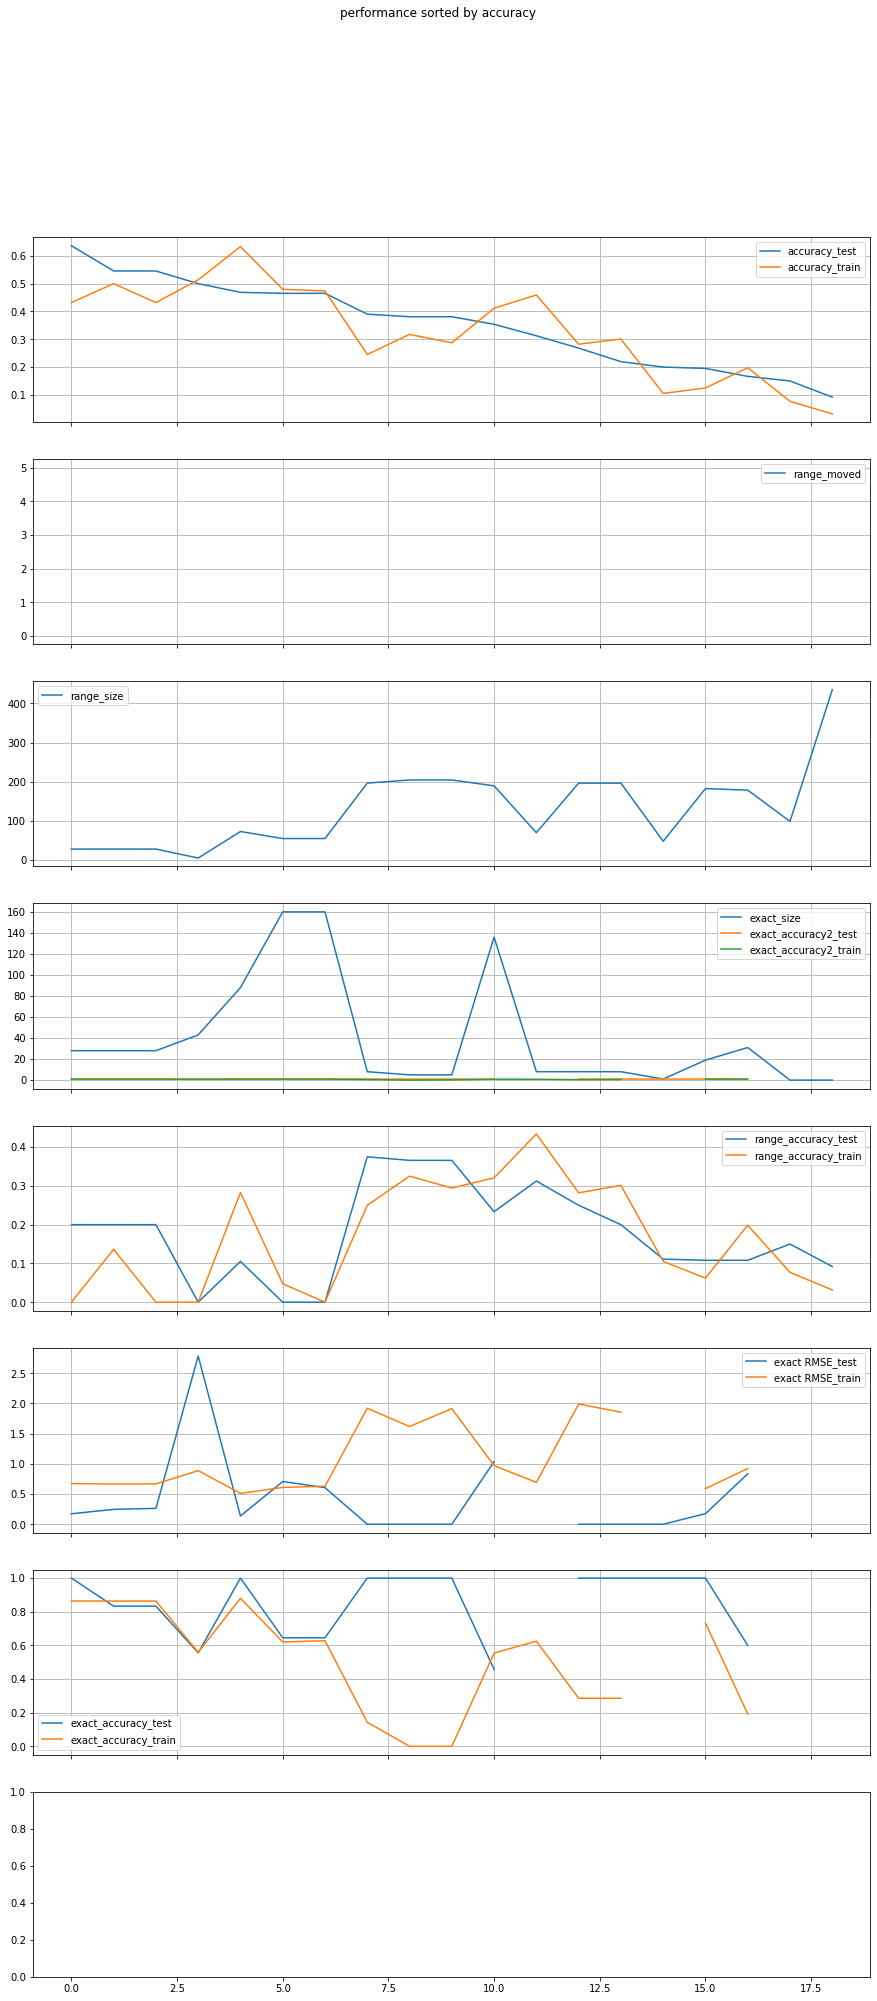

exp_path                              abaumannii_gentamicin_fixed_dup_striped_range_...
species                                                                      abaumannii
antibiotic                                                                   gentamicin
time_limit                                                                       3600.0
dup_drop                                                                           True
                                                            ...                        
('range_accuracy', 0.0, '>')_train                                                  NaN
('range_accuracy', 0.0, '>')_test                                                   NaN
exact_size                                                                         28.0
range_size                                                                         27.0
size                                                                               55.0
Name: 0, Length: 151, dtype: obj

In [334]:
metric='accuracy'
# metric='essential_agreement'
# metric='range_accuracy'
# metric='exact_accuracy2'
# metric='exact_accuracy'
metrices = ['accuracy', 'range_accuracy', 'exact_accuracy2', 'exact_accuracy', 'exact RMSE']
infos = ['range_moved', 'range_size', 'exact_size']
fig, axis = plt.subplots(len(metrices)+len(infos), sharex=True, figsize=(15,4*(len(metrices)++len(infos))))
fig.suptitle('performance sorted by {}'.format(metric))
results_by(results, metric)['{}_test'.format(metric)].plot(legend='test', ax=axis[0], grid=True)
results_by(results, metric)['{}_train'.format(metric)].plot(legend='test', ax=axis[0], grid=True)
for i, info in enumerate(infos):
    results_by(results, metric)[info].plot(legend='test', ax=axis[i+1], grid=True)
    
for i, met in enumerate(set(metrices)-set([metric])):
    results_by(results, metric)['{}_test'.format(met)].plot(legend='test', ax=axis[i+len(infos)], grid=True)
    results_by(results, metric)['{}_train'.format(met)].plot(legend='test', ax=axis[i+len(infos)], grid=True)
plt.show()
results_by(results, metric).iloc[0]

IndexError: index 9 is out of bounds for axis 0 with size 9

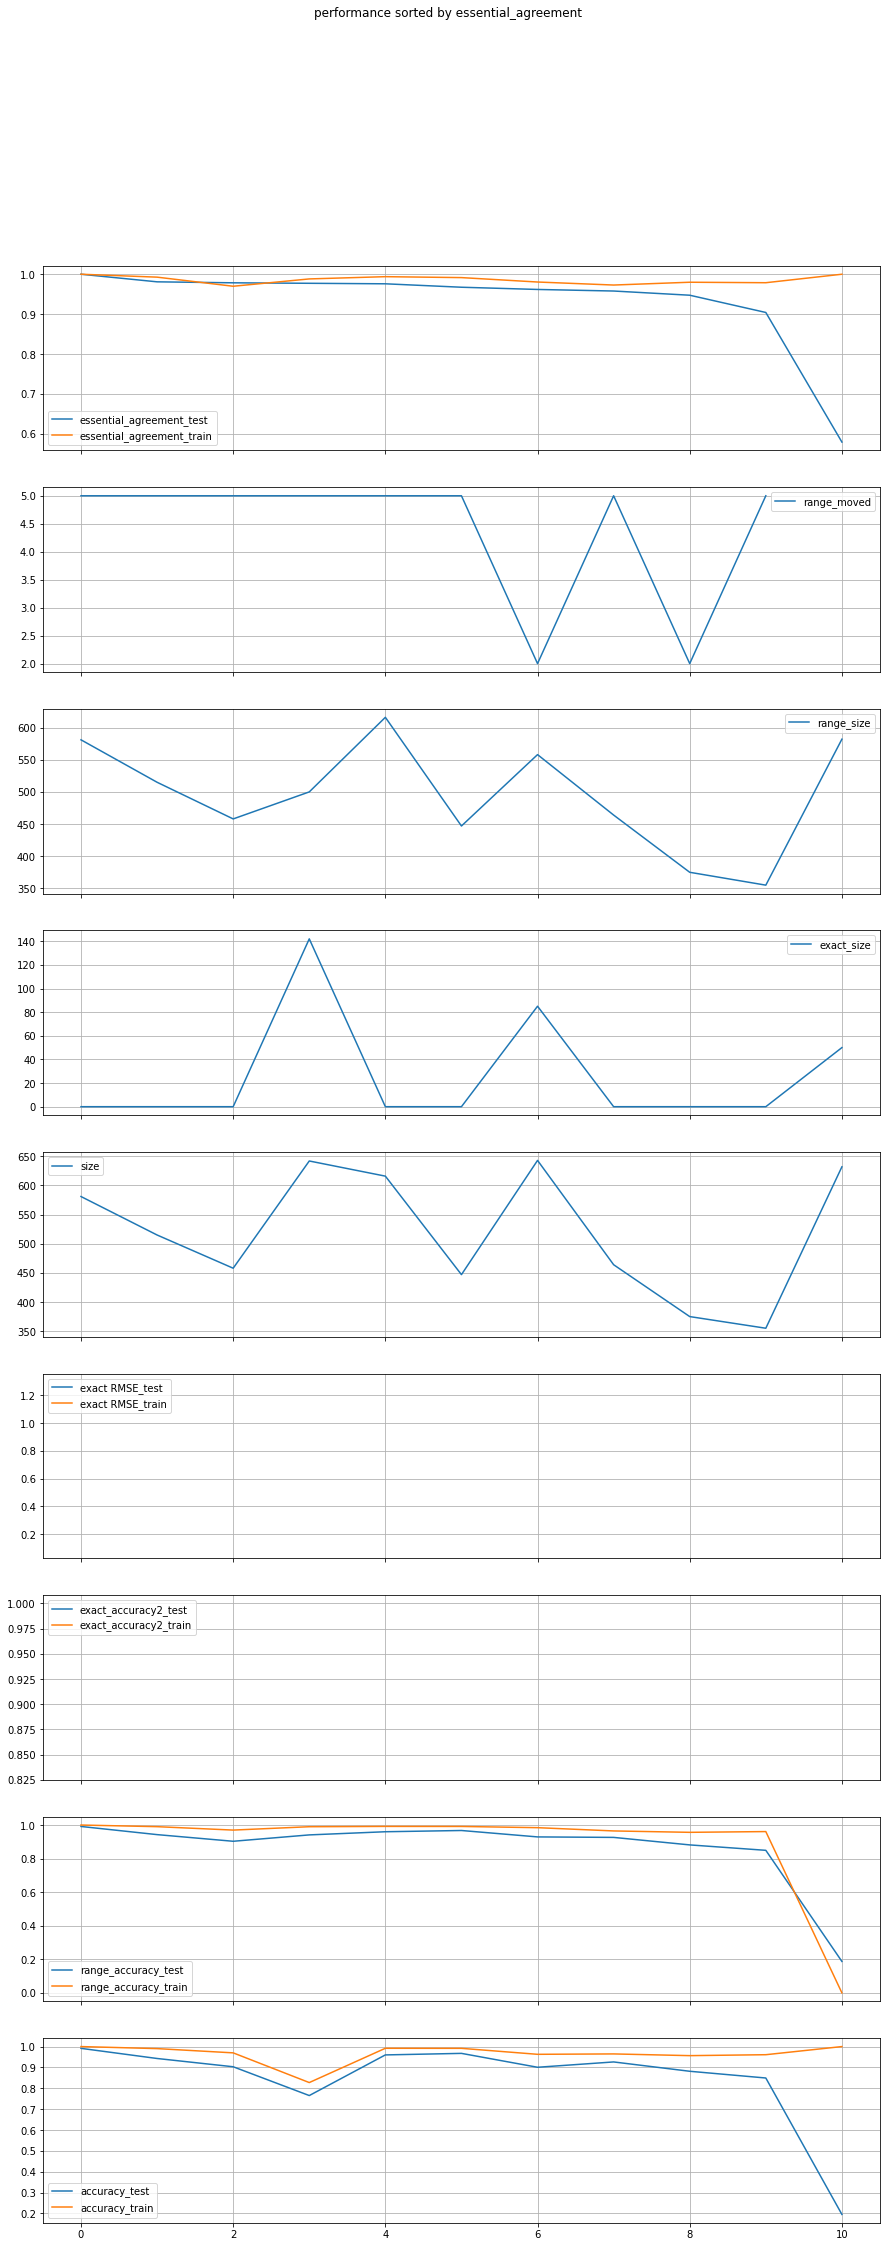

In [303]:
metric='accuracy'
metric='essential_agreement'
# metric='range_accuracy'
# metric='exact_accuracy2'
metrices = ['accuracy', 'range_accuracy', 'exact_accuracy2', 'exact_accuracy', 'exact RMSE']
infos = ['range_moved', 'range_size', 'exact_size', 'size']
fig, axis = plt.subplots(len(metrices)+len(infos), sharex=True, figsize=(15,4*(len(metrices)++len(infos))))
fig.suptitle('performance sorted by {}'.format(metric))
results_by(strat_results, metric)['{}_test'.format(metric)].plot(legend='test', ax=axis[0], grid=True)
results_by(strat_results, metric)['{}_train'.format(metric)].plot(legend='test', ax=axis[0], grid=True)
for i, info in enumerate(infos):
    results_by(strat_results, metric)[info].plot(legend='test', ax=axis[i+1], grid=True)
    
for i, met in enumerate(set(metrices)-set([metric])):
    results_by(strat_results, metric)['{}_test'.format(met)].plot(legend='test', ax=axis[i+1+len(infos)], grid=True)
    results_by(strat_results, metric)['{}_train'.format(met)].plot(legend='test', ax=axis[i+1+len(infos)], grid=True)
plt.show()
results_by(strat_results, metric)

In [42]:
explore_res = results.groupby(['species', 'antibiotic_name']).apply(lambda df: df.reset_index(drop=True).iloc[df['accuracy_test'].reset_index(drop=True).astype(float).idxmax(), :])

In [54]:
explore_res.to_csv('../res_summery.csv')

In [19]:
results.groupby(['species', 'antibiotic_name'])['range_accuracy_test'].max()

species      antibiotic_name              
abaumannii   amikacin                         0.095652
             ampicillin                       0.504425
             ampicillin-sulbactam             0.310811
             aztreonam                        0.846154
             cefazolin                        0.041667
             cefepime                         0.200000
             cefotaxime                       0.598039
             cefotetan                        0.150000
             cefoxitin                        0.091954
             ceftazidime                      0.472527
             ceftriaxone                      0.596491
             ciprofloxacin                    0.536585
             colistin                         0.000000
             doripenem                        0.157895
             gentamicin                       0.557522
             imipenem                         0.173333
             levofloxacin                     0.553398
             meropenem

In [75]:
results.groupby(['species', 'antibiotic_name'])['exact_accuracy_train'].max()

species      antibiotic_name              
abaumannii   amikacin                         0.526316
             ampicillin                       1.000000
             ampicillin-sulbactam             0.671171
             aztreonam                        0.725490
             cefazolin                             NaN
             cefepime                         0.863636
             cefotaxime                       0.555556
             cefotetan                             NaN
             cefoxitin                             NaN
             ceftazidime                      0.668790
             ceftriaxone                      0.530612
             ciprofloxacin                    0.857143
             colistin                         0.647059
             doripenem                        0.985714
             gentamicin                       0.852941
             imipenem                         0.679612
             levofloxacin                     0.911504
             meropenem

In [20]:
results.groupby(['species', 'antibiotic_name'])['exact_accuracy_test'].max()

species      antibiotic_name              
abaumannii   amikacin                         0.600000
             ampicillin                       1.000000
             ampicillin-sulbactam             0.584906
             aztreonam                        0.750000
             cefazolin                             NaN
             cefepime                         1.000000
             cefotaxime                       0.533333
             cefotetan                             NaN
             cefoxitin                             NaN
             ceftazidime                      0.717949
             ceftriaxone                      0.533333
             ciprofloxacin                    0.666667
             colistin                         0.555556
             doripenem                        1.000000
             gentamicin                       0.687500
             imipenem                         0.847826
             levofloxacin                     0.931034
             meropenem

### Examine criterion

In [21]:
criterion = 'accuracy_test'
accuracy_score = results.groupby(['species', 'antibiotic_name'])[criterion].max()
best_id = np.argsort(-accuracy_score.fillna(0)).values[1]
species, antibiotic_name = accuracy_score.index[best_id]
exp_name = results[np.logical_and(results['species']==species, results['antibiotic_name']==antibiotic_name)].sort_values(by=criterion, ascending=False).iloc[0].dropna()['exp_path']
results[np.logical_and(filtered_results['species']==species, filtered_results['antibiotic_name']==antibiotic_name)].sort_values(by=criterion, ascending=False).iloc[0].dropna()

NameError: name 'filtered_results' is not defined

In [108]:
exp_name

'abaumannii_tigecycline_fixed_dup_range_distanced_by2_for_60.0_min'

## Explore specific:

### specific exp_name

In [109]:
# exp_name = 'abaumannii_cefazolin_range_distanced_by2_for_60.0_min'
species = exp_name.split('_')[0]
antibiotic_name = exp_name.split('_')[1]

### specific species and antibiotic

In [62]:
species = 'abaumannii'
antibiotic_name = 'cefazolin'

### explore data distribution

/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (17,18,19,20,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (2,5,6,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/amitdanw/.conda/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

<IPython.core.display.Javascript object>


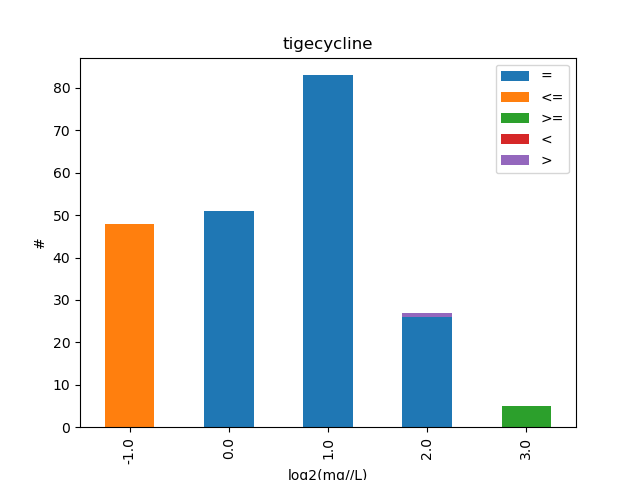

In [110]:
data = pd.read_csv('../resources/tot_filtered_data.csv')
with open("../resources/final_labels", "rb") as fp:
    labels = pickle.load(fp)
with open("../resources/final_features", "rb") as fp:
    features = pickle.load(fp)
ASR_data = pd.read_csv('../resources/filtered_ASR_data.csv')
species2merge = data[['biosample_id', 'species_fam']]
filtered_ASR = ASR_data.drop('species_fam', axis=1).merge(species2merge, on='biosample_id')
filtered_ASR = filtered_ASR[filtered_ASR['units']=='mg/L']
filtered_ASR = filtered_ASR[filtered_ASR['species_fam']!='senterica']
filtered_ASR = filtered_ASR[filtered_ASR['species_fam']!='spneumoniae']
filtered_ASR= filtered_ASR[filtered_ASR['species_fam']==species]
index_list = filtered_ASR['antibiotic_name'].value_counts().reset_index()
anti_id = index_list.index[index_list['index']==antibiotic_name].values[0]
print_anti_measure(filtered_ASR, anti_id)

In [111]:
results[np.logical_and(results['species']==species, results['antibiotic_name']==antibiotic_name)].dropna(axis=1)

,exp_path,species,antibiotic_name,hype_search_time,dup_drop,range,exact RMSE_train,exact RMSE_test,exact_rounded RMSE_train,exact_rounded RMSE_test,...,exact_size_test,accuracy_train,accuracy_test,exp_done,"('range_total', 3.0, '>')_test","('range_true', 3.0, '>')_test","('range_accuracy', 3.0, '>')_test","('range_total', -1.0, '<')_test","('range_true', -1.0, '<')_test","('range_accuracy', -1.0, '<')_test"
94,abaumannii_tigecycline_fixed_dup_train_no_rang...,abaumannii,tigecycline,60.0,True,no,0.599093,0.513911,0.678924,0.586302,...,32,0.992188,0.372093,True,5,0,0.0,48,0,0.0
163,abaumannii_tigecycline_fixed_dup_striped_range...,abaumannii,tigecycline,60.0,True,distanced,0.629164,0.606441,0.664726,0.672022,...,31,0.784147,0.697674,True,1,False,0.0,11,0,0.0
169,abaumannii_tigecycline_fixed_dup_range_distanc...,abaumannii,tigecycline,60.0,True,distanced,0.632102,0.671468,0.687654,0.595683,...,31,0.807621,0.72093,True,1,False,0.0,11,0,0.0
173,abaumannii_tigecycline_fixed_dup_range_distanc...,abaumannii,tigecycline,60.0,True,distanced,0.609996,0.707617,0.634902,0.803219,...,31,0.805983,0.651163,True,1,False,0.0,11,0,0.0


### Exact

In [112]:
label = pd.read_csv('../resources/label_{}.csv'.format(exp_name)).loc[0, 'label']
y_range = pd.read_csv('../resources/y_range_{}.csv'.format(exp_name)).set_index('biosample_id')
label

'tigecycline'

In [113]:
y = pd.read_csv('../resources/train_{}.csv'.format(exp_name)).set_index('biosample_id')[label]
train_res = pd.read_csv('../experiments/{}/oof_predictions.csv'.format(exp_name)).set_index('biosample_id').merge(y, left_index=True, right_index=True, how='inner')
train_res = train_res.loc[set(train_res.index)-set(y_range.index)]
train_res.columns=['y_pred', 'y_true']
train_res['y_true'] = np.round(train_res['y_true'])
min_true = train_res['y_true'].min()
max_true = train_res['y_true'].max(axis=0)
train_res['y_pred'] = train_res['y_pred'].clip(lower=min_true, upper=max_true)
train_res['residual'] = train_res['y_true'] - train_res['y_pred']
train_res['y_pred'] = np.round(train_res['y_pred'])
train_res['round_residual'] = train_res['y_true'] - train_res['y_pred']
train_res.describe()

,y_pred,y_true,residual,round_residual
count,129.000000,129.000000,129.000000,129.000000
mean,0.767442,0.837209,0.044121,0.069767
std,0.593080,0.682261,0.633018,0.686773
min,0.000000,0.000000,-1.399280,-1.000000
25%,0.000000,0.000000,-0.210025,0.000000
50%,1.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.456601,0.000000
max,2.000000,2.000000,2.000000,2.000000


In [114]:
y = pd.read_csv('../resources/test_{}.csv'.format(exp_name)).set_index('biosample_id')[label]
test_res = pd.read_csv('../experiments/{}/test_predictions.csv'.format(exp_name)).set_index('biosample_id').merge(y, left_index=True, right_index=True, how='inner')
test_res = test_res.loc[set(test_res.index)-set(y_range.index)]
test_res.columns=['y_pred', 'y_true']
test_res['y_true'] = np.round(test_res['y_true'])
min_true = test_res['y_true'].min()
max_true = test_res['y_true'].max(axis=0)
test_res['y_pred'] = test_res['y_pred'].clip(lower=min_true, upper=max_true)
test_res['residual'] = test_res['y_true'] - test_res['y_pred']
test_res['y_pred'] = np.round(test_res['y_pred'])
test_res['round_residual'] = test_res['y_true'] - test_res['y_pred']
test_res.describe()

,y_pred,y_true,residual,round_residual
count,31.000000,31.000000,31.000000,31.000000
mean,0.903226,0.870968,-0.074593,-0.032258
std,0.472923,0.670420,0.678342,0.604642
min,0.000000,0.000000,-1.293194,-1.000000
25%,1.000000,0.000000,-0.323517,0.000000
50%,1.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,0.316177,0.000000
max,2.000000,2.000000,1.499168,1.000000


In [115]:
for key, res in {'Train': train_res, 'Test': test_res}.items():
    print(key)
    print('RMSE: {}'.format(res['residual'].std()))
    print('RMSE after rounding: {}'.format(res['round_residual'].std()))

Train
RMSE: 0.6330183864075964
RMSE after rounding: 0.6867728712931125
Test
RMSE: 0.6783424829851445
RMSE after rounding: 0.604641544925142


In [116]:
regression_res = pd.DataFrame({
    'exact RMSE': [np.sqrt(train_res['residual'].pow(2).mean()), np.sqrt(test_res['residual'].pow(2).mean())],
    'exact_rounded RMSE': [np.sqrt(train_res['round_residual'].pow(2).mean()), np.sqrt(test_res['round_residual'].pow(2).mean())],
}, index=['train', 'test'])
regression_res

,exact RMSE,exact_rounded RMSE
train,0.632102,0.687654
test,0.671468,0.595683


<IPython.core.display.Javascript object>


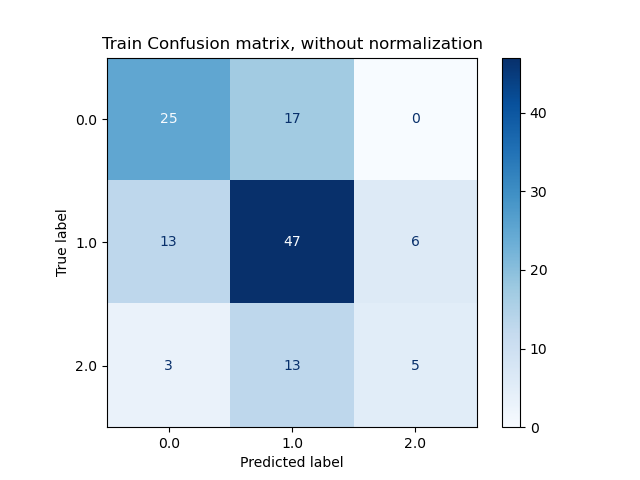

<IPython.core.display.Javascript object>


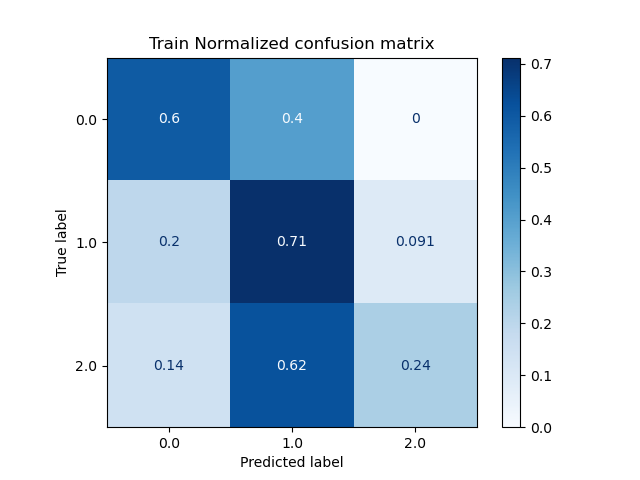

<IPython.core.display.Javascript object>


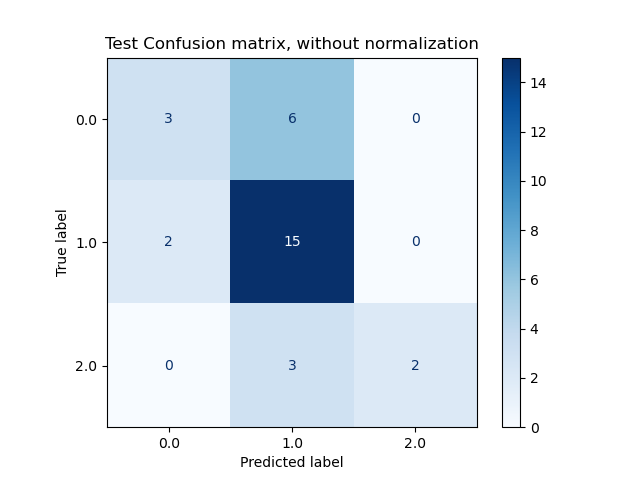

<IPython.core.display.Javascript object>


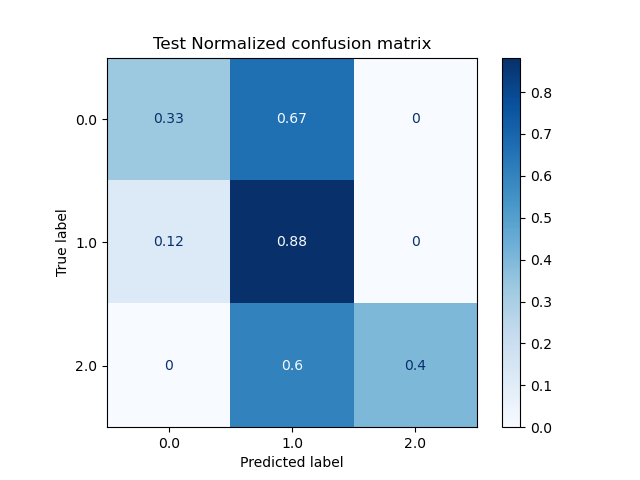

In [117]:
for key, res in {'Train': train_res, 'Test': test_res}.items():
    titles_options = [
        (key+ " Confusion matrix, without normalization", None),
        (key+" Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_predictions(
            np.round(res['y_true']),
            res['y_pred'],
            labels=np.sort(list(set(list(np.round(res['y_true']).unique())).union(set(list(np.round(res['y_pred']).unique()))))),
    #         display_labels=np.sort(list(train_res['y_true'].unique())),
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)
        cm = pd.DataFrame(disp.confusion_matrix, index=disp.display_labels, columns=disp.display_labels)
        cm.columns.name='predicted_labels'
        cm.index.name='true_labels'
        cm.to_csv('../experiments/{}/{}_df_confusion_matrix_{}.csv'.format(exp_name, key, normalize))
        plt.savefig('../experiments/{}/{}_confusion_matrix_{}.png'.format(exp_name, key, normalize), format='png')
plt.show()

In [118]:
train_res['error'] = train_res['round_residual'].abs() <2
train_res['error'].describe()

count      129
unique       2
top       True
freq       126
Name: error, dtype: object

In [119]:
train_res['error'].mean()

0.9767441860465116

In [120]:
test_res['error'] = test_res['round_residual'].abs() <2
test_res['error'].describe()

count       31
unique       1
top       True
freq        31
Name: error, dtype: object

In [121]:
test_res['error'].mean()

1.0

### range result

In [122]:
equal_meaning = True
dup_drop = len(exp_name.split('fixed_dup'))>1 
if dup_drop:
    id_col = 'biosample_id'
else:
    id_col = 'unique_id'

In [123]:
range_res = pd.read_csv('../experiments/{}/range_preds.csv'.format(exp_name)).set_index(id_col).merge(y_range, left_index=True, right_index=True, how='inner')
range_res.columns=['y_pred'] + list(range_res.columns.values)[1:]
range_res['values'] = np.round(range_res['values'])
range_res['updated_values'] = np.nan
range_res['updated_direction'] = np.nan
if equal_meaning:
        range_res.loc[range_res['direction'] == '>=','updated_values'] = range_res['values'] - 1
        range_res.loc[range_res['direction'] == '<=','updated_values'] = range_res['values'] + 1
range_res.loc[range_res['direction'] == '>=','updated_direction'] = '>'
range_res.loc[range_res['direction'] == '<=','updated_direction'] = '<'

range_res.loc[:,'updated_values'].fillna(range_res['values'], inplace=True)
range_res.loc[:,'updated_direction'].fillna(range_res['direction'], inplace=True)

range_res.loc[range_res['updated_direction'] == '>','answer'] = (range_res['y_pred'] > range_res['updated_values'])
range_res.loc[range_res['updated_direction'] == '<','answer'] = (range_res['y_pred'] < range_res['updated_values'])
y = pd.read_csv('../resources/train_{}.csv'.format(exp_name)).set_index(id_col)[label]
train_res = pd.read_csv('../experiments/{}/oof_predictions.csv'.format(exp_name)).set_index(id_col).merge(y, left_index=True, right_index=True, how='inner')
train_range_res = range_res.loc[set(range_res.index).intersection(set(train_res.index))]
test_range_res = range_res.loc[set(range_res.index) - set(train_res.index)]
for key, res in {'train': train_range_res, 'test': test_range_res}.items():
    range_confusion = res.groupby(by=['direction', 'values'])['answer'].agg(['count', 'sum']).replace(True, 1)
    range_confusion['perc'] = range_confusion['sum'] / range_confusion['count']
    range_confusion.columns = ['total', 'in range', 'accuracy']
    range_confusion = pd.DataFrame(range_confusion.stack()).T.swaplevel(i=2, j=0, axis=1)
    range_confusion.index=[key]
    regression_res = pd.concat([regression_res, range_confusion], axis=1)
regression_res_cleaned = pd.DataFrame({})
for col in regression_res.columns:
    if len(regression_res[[col]].columns) > 1:
        regression_res_cleaned[col] = regression_res[[col]].iloc[:,0].fillna(regression_res[[col]].iloc[:,1])
    else:
        regression_res_cleaned[col] = regression_res[[col]]
regression_res = regression_res_cleaned

In [124]:
test_range_res['answer'].mean()

0.0

In [125]:
regression_res

,exact RMSE,exact_rounded RMSE,"(total, -1.0, <)","(in range, -1.0, <)","(accuracy, -1.0, <)","(total, 2.0, >)","(in range, 2.0, >)","(accuracy, 2.0, >)","(total, 3.0, >)","(in range, 3.0, >)","(accuracy, 3.0, >)"
train,0.632102,0.687654,37,5,0.135135,1,False,0.0,4,0,0.0
test,0.671468,0.595683,11,0,0.000000,NaN,NaN,NaN,1,False,0.0


In [26]:
regression_res.to_csv('../experiments/{}/df_regression_results.csv'.format(exp_name))

In [27]:
label

'ampicillin-sulbactam'

## Playing with h2o

In [106]:
filtered_data.head()

,tet(C)->seq_id,eptA->seq_id,TEM-206->seq_cov,Nocardia_rifampin_resistant_beta-subunit_of_RNA_polymerase_(rpoB2)->seq_id,dfrA16->seq_id,sdiA->seq_id,SHV-134->seq_cov,CTX-M-55->seq_cov,AAC(3)-VIa->seq_id,SHV-134->seq_id,...,msrE->seq_id,ugd->seq_cov,Klebsiella_pneumoniae_KpnF->seq_cov,aadA7->seq_cov,aadA12->seq_cov,Escherichia_coli_ampH->seq_cov,EreA2->seq_id,QnrA1->seq_cov,baeR->seq_id,ciprofloxacin
unique_id,,,,,,,,,,,,,,,,,,,,,
SAMN05771806PATAKI,0.0,76.97,0.0,75.33,0.0,100.00,0.0,0.0,0.0,0.0,...,0.0,99.83,99.7,0.0,0.0,100.0,0.0,0.0,81.72,-6.058894
SAMN05771805PATAKI,0.0,76.97,0.0,75.33,0.0,100.00,0.0,0.0,0.0,0.0,...,0.0,99.83,99.7,0.0,0.0,100.0,0.0,0.0,81.72,-6.058894
SAMN05771804PATAKI,0.0,76.97,0.0,75.33,0.0,100.00,0.0,0.0,0.0,0.0,...,0.0,99.83,99.7,0.0,0.0,100.0,0.0,0.0,81.72,-6.058894
SAMN05771803PATAKI,0.0,76.97,0.0,75.33,0.0,100.00,0.0,0.0,0.0,0.0,...,0.0,99.83,99.7,0.0,0.0,100.0,0.0,0.0,81.72,-6.058894
SAMN05771802PATAKI,0.0,77.16,0.0,75.58,0.0,98.75,0.0,0.0,0.0,0.0,...,0.0,99.83,99.7,0.0,0.0,100.0,0.0,0.0,81.58,-6.058894


In [107]:
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

# Import a sample binary outcome train/test set into H2O
trainH2o = h2o.import_file('../resources/train_{}_naive.csv'.format(y.name))
testH2o = h2o.import_file('../resources/test_{}_naive.csv'.format(y.name))

# Identify predictors and response
x = features
y = label

# Run AutoML for 20 base models
aml = H2OAutoML(max_models=100, seed=1, max_runtime_secs=86400)
aml.train(x=x, y=y, training_frame=trainH2o)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

# model_id                                                  auc    logloss    mean_per_class_error      rmse       mse
# ---------------------------------------------------  --------  ---------  ----------------------  --------  --------
# StackedEnsemble_AllModels_AutoML_20181212_105540     0.789801   0.551109                0.333174  0.43211   0.186719
# StackedEnsemble_BestOfFamily_AutoML_20181212_105540  0.788425   0.552145                0.323192  0.432625  0.187165
# XGBoost_1_AutoML_20181212_105540                     0.784651   0.55753                 0.325471  0.434949  0.189181
# XGBoost_grid_1_AutoML_20181212_105540_model_4        0.783523   0.557854                0.318819  0.435249  0.189441
# XGBoost_grid_1_AutoML_20181212_105540_model_3        0.783004   0.559613                0.325081  0.435708  0.189841
# XGBoost_2_AutoML_20181212_105540                     0.78136    0.55888                 0.347074  0.435907  0.190015
# XGBoost_3_AutoML_20181212_105540                     0.780847   0.559589                0.330739  0.43613   0.190209
# GBM_5_AutoML_20181212_105540                         0.780837   0.559903                0.340848  0.436191  0.190263
# GBM_2_AutoML_20181212_105540                         0.780036   0.559806                0.339926  0.436415  0.190458
# GBM_1_AutoML_20181212_105540                         0.779827   0.560857                0.335096  0.436616  0.190633
# GBM_3_AutoML_20181212_105540                         0.778669   0.56179                 0.325538  0.437189  0.191134
# XGBoost_grid_1_AutoML_20181212_105540_model_2        0.774411   0.575017                0.322811  0.4427    0.195984
# GBM_4_AutoML_20181212_105540                         0.771426   0.569712                0.33742   0.44107   0.194543
# GBM_grid_1_AutoML_20181212_105540_model_1            0.769752   0.572583                0.344331  0.442452  0.195764
# GBM_grid_1_AutoML_20181212_105540_model_2            0.754366   0.918567                0.355855  0.496638  0.246649
# DRF_1_AutoML_20181212_105540                         0.742892   0.595883                0.355403  0.452774  0.205004
# XRT_1_AutoML_20181212_105540                         0.742091   0.599346                0.356583  0.453117  0.205315
# DeepLearning_grid_1_AutoML_20181212_105540_model_2   0.741795   0.601497                0.368291  0.454904  0.206937
# XGBoost_grid_1_AutoML_20181212_105540_model_1        0.693554   0.620702                0.40588   0.465791  0.216961
# DeepLearning_1_AutoML_20181212_105540                0.69137    0.637954                0.409351  0.47178   0.222576
# DeepLearning_grid_1_AutoML_20181212_105540_model_1   0.690084   0.661794                0.418469  0.476635  0.227181
# GLM_grid_1_AutoML_20181212_105540_model_1            0.682648   0.63852                 0.397234  0.472683  0.223429
#
# [22 rows x 6 columns]

# The leader model is stored here
aml.leader

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 min 10 secs
H2O_cluster_timezone:,Asia/Jerusalem
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.1
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_amitdanw_auth_ad_bgu_ac_il_bd4fw5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.200 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
23:23:59.206: _train param, Dropping bad and constant columns: [AAC(3)-IIb->seq_cov, dfrA5->seq_cov, AAC(6')-IIc->seq_cov, AAC(3)-IIb->seq_id, dfrA5->seq_id, EreA2->seq_cov, Klebsiella_pneumoniae_KpnH->seq_id, Escherichia_coli_acrA->seq_cov, catII_from_Escherichia_coli_K-12->seq_cov, EreA2->seq_id, Klebsiella_pneumoniae_KpnH->seq_cov, AAC(6')-IIc->seq_id, LAP-2->seq_id, catII_from_Escherichia_coli_K-12->seq_id, LAP-2->seq_cov]

██
23:24:06.254: _train param, Dropping bad and constant columns: [AAC(3)-IIb->seq_cov, dfrA5->seq_cov, AAC(6')-IIc->seq_cov, AAC(3)-IIb->seq_id, dfrA5->seq_id, EreA2->seq_cov, Klebsiella_pneumoniae_KpnH->seq_id, Escherichia_coli_acrA->seq_cov, catII_from_Escherichia_coli_K-12->seq_cov, EreA2->seq_id, Klebsiella_pneumoniae_KpnH->seq_cov, AAC(6')-IIc->seq_id

In [ ]:
preds = aml.predict(testH2o)

## Playing with Amoxicillin - Clavulanic acid as regression

In [223]:
X = filtered_data[features]
y = filtered_data[best_label+'_filtered']

In [226]:
kf = KFold(n_splits=10, shuffle=True, random_state=rng)

In [228]:
tot_actuals = []
tot_predictions = []
tot_rounded_predictions = []
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor(n_jobs=1, tree_method='gpu_hist', gpu_id=0).fit(X.iloc[train_index], y.iloc[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    rounded_predictions = [min(final_dict.values(), key=lambda x:abs(x-pred)) for pred in predictions]
    print("rounded: ", rounded_predictions)
    print("actual: ", actuals.T[0])
    print(mean_squared_error(actuals, predictions))
    print(confusion_matrix([str(x) for x in actuals.T[0]], [str(x) for x in rounded_predictions]))
    tot_actuals += list(actuals.T[0])
    tot_rounded_predictions += rounded_predictions
    tot_predictions += list(predictions)

XGBoostError: [11:31:40] /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/gbm/../common/common.h:157: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1a393b) [0x7f992193f93b]
  [bt] (1) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1a39cc) [0x7f992193f9cc]
  [bt] (2) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(xgboost::gbm::GBTree::ConfigureUpdaters()+0xa5) [0x7f992193fa85]
  [bt] (3) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(xgboost::gbm::GBTree::Configure(std::vector<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > >, std::allocator<std::pair<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > > const&)+0x309) [0x7f9921956039]
  [bt] (4) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1e67fd) [0x7f99219827fd]
  [bt] (5) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(+0x1d5787) [0x7f9921971787]
  [bt] (6) /home/amitdanw/.conda/envs/gps/lib/libxgboost.so(XGBoosterUpdateOneIter+0x4c) [0x7f9921855abc]
  [bt] (7) /home/amitdanw/.conda/envs/gps/lib/python3.10/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f999bbf1a4a]
  [bt] (8) /home/amitdanw/.conda/envs/gps/lib/python3.10/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f999bbf0fea]



In [291]:
print(mean_squared_error(tot_actuals, tot_predictions))

0.7742366563759465


<IPython.core.display.Javascript object>


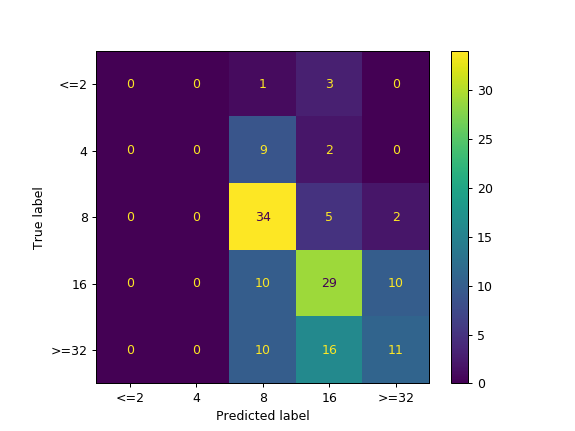

In [292]:
cm = confusion_matrix(
    [str(x) for x in tot_actuals], 
    [str(x) for x in tot_rounded_predictions], 
    labels=[str(x) for x in final_dict.values()],
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[str(x) for x in final_dict.keys()],
)
disp.plot() 

### run Parameter Opt

In [319]:
param_grid = {
    'max_depth':[3, 4, 6, 8, 10], 
    'n_estimators': [20, 50, 100, 200],
    'eta': uniform(loc=0, scale=1),
    'gamma': uniform(loc=0, scale=100),
    'min_child_weight': uniform(loc=0, scale=10),
    ''
}

In [320]:
xgb_model = xgb.XGBRegressor(n_jobs=1, tree_method='gpu_hist', gpu_id=0)

In [321]:
kf = KFold(n_splits=10, shuffle=True, random_state=rng)

In [322]:
clf = RandomizedSearchCV(xgb_model, param_distributions=param_grid, random_state=rng, cv = kf)

In [323]:
search = clf.fit(X, y)
search.best_params_
search.best_score_

[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

0.2719582886878314

[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:35:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

<IPython.core.display.Javascript object>


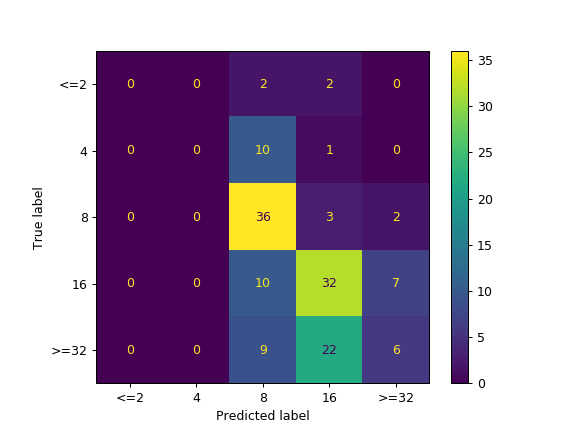

In [324]:
tot_actuals = []
tot_predictions = []
tot_rounded_predictions = []
for train_index, test_index in kf.split(X):
    xgb_model = xgb.XGBRegressor(n_jobs=1, **search.best_params_).fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    rounded_predictions = [min(final_dict.values(), key=lambda x:abs(x-pred)) for pred in predictions]
    tot_actuals += list(actuals.T[0])
    tot_rounded_predictions += rounded_predictions
    tot_predictions += list(predictions)
    
print(mean_squared_error(tot_actuals, tot_predictions))
cm = confusion_matrix(
    [str(x) for x in tot_actuals], 
    [str(x) for x in tot_rounded_predictions], 
    labels=[str(x) for x in final_dict.values()],
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[str(x) for x in final_dict.keys()],
)
disp.plot() 

In [318]:
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)